<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Примените подход к музыке как к тексту и напишите сверточный классификатор для подготовленных данных. Для этого:

 1. Измените подготовку данных так, чтобы набор признаков, извлекаемый из аудиофайла, был представлен в виде последовательностей векторов признаков. Последовательности должны быть фиксированного размера и выбираться скользящим окном c заданным шагом;
 2. Длину последовательности, размер шага и достаточный набор признаков определите самостоятельно исходя из требований к точности классификатора;
 3. Разработайте классификатор на одномерных сверточных слоях **Conv1D** с точностью классификации жанра на тестовых данных не ниже **60%**, а на обучающих файлах - **68%** и выше;
 4. Используйте за основу фреймворк с урока, но при желании разработайте свои инструменты.
 

Импортируем необходимые библиотеки:

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

Загрузим датасет в Colab:

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/genres.zip', None, quiet=True)

'genres.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres 

# Проверка содержимого одной папки
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
# Ваше решение
# Установка констант

# Папка с файлами датасета
FILE_DIR = './genres'

# Список классов
CLASS_LIST = os.listdir(FILE_DIR)

# Количество классов
CLASS_COUNT = len(CLASS_LIST)

# Размер окна преобразования Фурье для расчета спектра
N_FFT = 8192

# Количество аудиосэмплов между соседними столбцами БПФ
HOP_LENGTH = 512

In [ ]:
# Отсортируем список классов для фиксации порядка меток
CLASS_LIST.sort()

In [ ]:
# Функция формирования набора данных из файлов всех классов

def extract_data():

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Для всех классов:
    for i, genre in enumerate(CLASS_LIST):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for j in range(100):
            # Извлечение имени произведения
            song_name = f'{FILE_DIR}/{genre}/{genre}.{str(j).zfill(5)}.au'
            
            # Загрузка данных аудиосигнала
            y, sr = librosa.load(song_name, duration=30)
            
            features = None
            
            # Вычисление различных параметров (признаков) аудио
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
            features = chroma_stft
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
            features = np.vstack((features, mfcc))
            rmse = librosa.feature.rms(y=y, hop_length=HOP_LENGTH)
            features = np.vstack((features, rmse))
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
            features = np.vstack((features, spec_cent))
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
            features = np.vstack((features, spec_bw))
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
            features = np.vstack((features, rolloff))
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=HOP_LENGTH)
            features = np.vstack((features, zcr))

            # транспонируем матрицу признаков
            features = features.T

            # Перевод номера класса в one hot encoding
            y_label = to_categorical(i, CLASS_COUNT)
            y_label = np.reshape(y_label, (1, 10))
            y_label = np.repeat(y_label, features.shape[0], axis=0)
            
            # добавляем данные в списки
            x_data = features if x_data is None else np.vstack([x_data, features])
            y_data = y_label if y_data is None else np.vstack([y_data, y_label])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {genre} добавлен в датасет')

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
x, y = extract_data()

Жанр blues добавлен в датасет
Жанр classical добавлен в датасет
Жанр country добавлен в датасет
Жанр disco добавлен в датасет
Жанр hiphop добавлен в датасет
Жанр jazz добавлен в датасет
Жанр metal добавлен в датасет
Жанр pop добавлен в датасет
Жанр reggae добавлен в датасет
Жанр rock добавлен в датасет


In [ ]:
# Вывод формы данных обучающего набора
print(x.shape)
print(y.shape)

(1291998, 37)
(1291998, 10)


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(x)

In [ ]:
x_scaled = np.expand_dims(x_scaled, axis=2)

In [ ]:
# Разделение набора данных на обучающую и тестовую выборки
x_data, x_test, y_data, y_test = train_test_split(x_scaled, y, test_size=0.1)

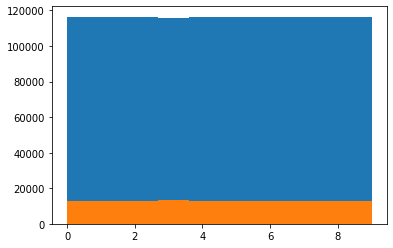

In [ ]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_data, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_test, axis=1), CLASS_COUNT)
plt.show()

In [ ]:
# Разделение набора данных на обучающую и валидационную выборки
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, stratify=y_data, test_size=0.1)

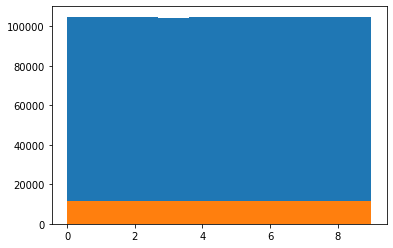

In [ ]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(1046518, 37, 1)
(116280, 37, 1)
(1046518, 10)
(116280, 10)


In [ ]:
# модель
model = Sequential()
model.add(Conv1D(20, 5, activation='relu', padding='same',input_shape=(37, 1) ))
model.add(Conv1D(20, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(20, 5, activation='relu', padding='same'))
model.add(Conv1D(20, 5, activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
4088/4088 [==============================] - 25s 6ms/step - loss: 1.2311 - accuracy: 0.5607 - val_loss: 1.0793 - val_accuracy: 0.6132
Epoch 2/100
4088/4088 [==============================] - 24s 6ms/step - loss: 1.0500 - accuracy: 0.6255 - val_loss: 1.0246 - val_accuracy: 0.6346
Epoch 3/100
4088/4088 [==============================] - 23s 6ms/step - loss: 0.9965 - accuracy: 0.6454 - val_loss: 0.9943 - val_accuracy: 0.6458
Epoch 4/100
4088/4088 [==============================] - 23s 6ms/step - loss: 0.9664 - accuracy: 0.6570 - val_loss: 0.9734 - val_accuracy: 0.6558
Epoch 5/100
4088/4088 [==============================] - 23s 6ms/step - loss: 0.9460 - accuracy: 0.6645 - val_loss: 0.9471 - val_accuracy: 0.6649
Epoch 6/100
4088/4088 [==============================] - 23s 6ms/step - loss: 0.9306 - accuracy: 0.6699 - val_loss: 0.9316 - val_accuracy: 0.6709
Epoch 7/100
4088/4088 [==============================] - 23s 6ms/step - loss: 0.9187 - accuracy: 0.6744 - val_loss: 0.9253 -

3634/3634 [==============================] - 11s 3ms/step - loss: 0.8526 - accuracy: 0.6973
Точность: 0.697273850440979


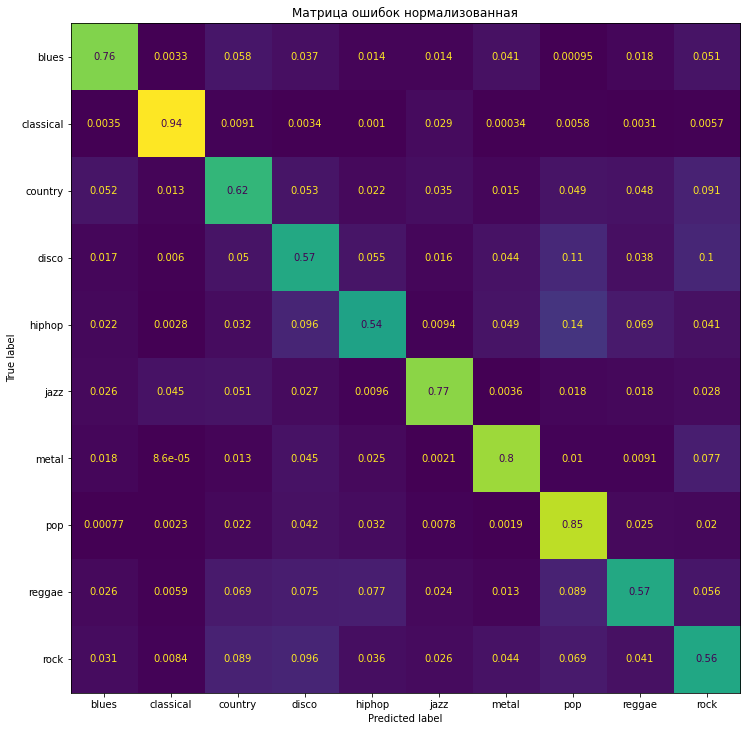

In [ ]:
# Оценка точности модели на валидационной выборке
loss, acc = model.evaluate(x_val, y_val)
print(f'Точность: {acc}')

# Построение матрицы ошибок
y_pred = model.predict(x_val)
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1),
                      normalize='true')

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Матрица ошибок нормализованная')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
disp.plot(ax=ax)
plt.gca().images[-1].colorbar.remove()
plt.show()

4038/4038 [==============================] - 13s 3ms/step - loss: 0.8570 - accuracy: 0.6952
Точность: 0.6952244639396667


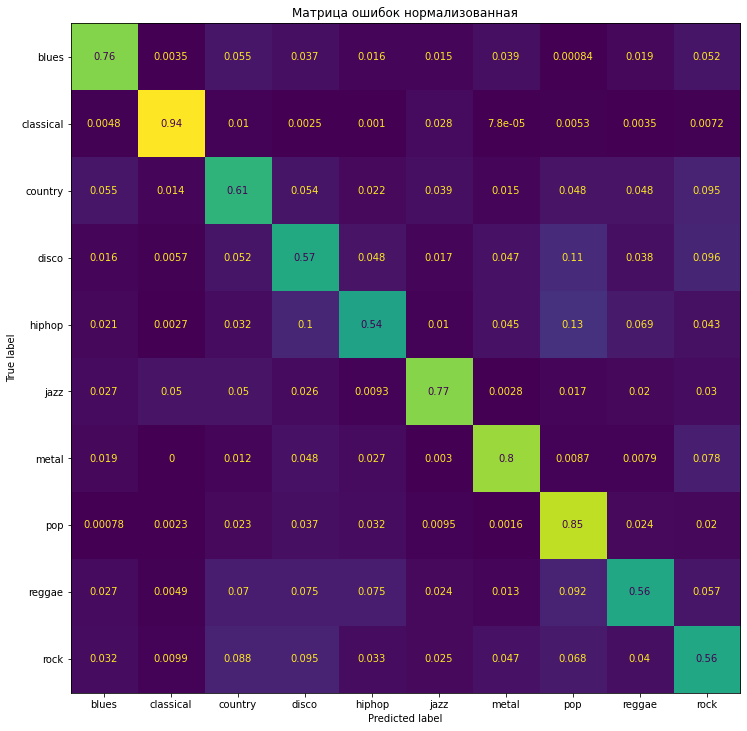

In [ ]:
# Оценка точности модели на тестовой выборке
loss, acc = model.evaluate(x_test, y_test)
print(f'Точность: {acc}')

# Построение матрицы ошибок
y_pred = model.predict(x_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1),
                      normalize='true')

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Матрица ошибок нормализованная')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
disp.plot(ax=ax)
plt.gca().images[-1].colorbar.remove()
plt.show()

Необходимая точность достигнута